<a href="https://colab.research.google.com/github/helmana/DLeeg/blob/master/2ch%20_20s(5-2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mne


     |████████████████████████████████| 6.3MB 2.4MB/s 
  Stored in directory: /root/.cache/pip/wheels/71/40/30/fb9a9bdeac02c6b3b144be66ac345c5b5587a7d7610564535b
Successfully built mne


In [2]:
import matplotlib

from matplotlib import pyplot as plt
import numpy as np



import random
import mne
from mne.preprocessing import create_ecg_epochs, create_eog_epochs
from mne import io
from mne import viz
#from mne.datasets import testing
from mne import Epochs, io, pick_types
from mne.event import define_target_events
from mne.time_frequency import psd_welch
print(__doc__)

Automatically created module for IPython interactive environment


In [3]:
subject_number=20


# load dataset in array
list_raw_fnames = [[0]*2]*subject_number
for x in range(subject_number):
    list_raw_fnames[x] = mne.datasets.eegbci.load_data(x+1,[1,2])

list_rawdata = np.zeros((subject_number,2), dtype='object')

for i in range(subject_number):
    for j in range(2):
        list_rawdata[i][j] = mne.io.read_raw_edf(list_raw_fnames[i][j], preload=True)
print( list_rawdata[:][:])

Using default location ~/mne_data for EEGBCI...
Creating ~/mne_data
[........................................] 100.00% (  1.2 MB,  22.4 MB/s) |   
Do you want to set the path:
    /root/mne_data
as the default EEGBCI dataset path in the mne-python config [y]/n? y
Attempting to create new mne-python configuration file:
/root/.mne/mne-python.json
[........................................] 100.00% (  1.2 MB,  29.0 MB/s) |   
[........................................] 100.00% (  1.2 MB,  18.9 MB/s) |   
[........................................] 100.00% (  1.2 MB,  29.2 MB/s) |   
[........................................] 100.00% (  1.2 MB,  30.2 MB/s) |   
[........................................] 100.00% (  1.2 MB,  19.1 MB/s) |   
[........................................] 100.00% (  1.2 MB,  28.2 MB/s) |   
[........................................] 100.00% (  1.2 MB,  26.5 MB/s) |   
[........................................] 100.00% (  1.2 MB,  26.3 MB/s) |   
[....................

In [4]:
import math


task_number=1
task_time = 60
sampel_number_per_sec =  160 # sampel rate
total_sampel_number =  sampel_number_per_sec *task_time # 60*160
sample_shift = 4 #step len
window_len= 20

# img for each one
subject_img_number = math.floor((total_sampel_number - sampel_number_per_sec) / sample_shift) +1 - window_len +1
test_start_index=subject_img_number - math.floor(subject_img_number/4) 

train_number =  test_start_index 
test_number = subject_img_number - test_start_index
train_number

1757

In [5]:
ch_number = 2

train_img = np.zeros((train_number*subject_number, ch_number, window_len + 1, 160), dtype = float)
train_label =[]


test_img = np.zeros((test_number*subject_number, ch_number, window_len, 160), dtype = float)
test_label =[]


train_img.shape

(35140, 2, 21, 160)

In [0]:

def normalize_channel_data(ch , i, ch_min, ch_max):
  ch = ((ch - ch_min[i]) / (ch_max[i] - ch_min[i] ) )
  return ch

In [0]:
for s in range(subject_number):
    rawdataChannels_t, times_t=rawdataChannels, times =list_rawdata[s][0][:64,:9600]
    ch_max =[]
    ch_min =[]
    for p in range(len(rawdataChannels_t)):
        ch_max = np.append(ch_max, max(rawdataChannels_t[p])) # max for each cannel
        ch_min = np.append(ch_min, min(rawdataChannels_t[p])) # min for each cannel

    for j in range (subject_img_number):
        for i in range(ch_number):
            for z in range (window_len):
                rawdataChannels, times=rawdataChannels, times =list_rawdata[s][0][i,0+(j+z)*sample_shift:sampel_number_per_sec+(j+z)*sample_shift]

                      # normalize method
                rawdataChannels = normalize_channel_data(rawdataChannels, i, ch_min, ch_max)
                if j <test_start_index :
                    train_img[s*train_number + j][i][z] = rawdataChannels
                    if z==window_len-1 :
                      train_img[s*train_number + j][i][z+1] = s
                      
                      
                else:
                    test_img[s*test_number + j - test_start_index][i][z] = rawdataChannels
        if j >=test_start_index :
          test_label = np.append(test_label, (s))

In [0]:
#shaffle train img array
train_img_shuffle = train_img

np.random.shuffle(train_img_shuffle)

In [0]:
train_img_2 = np.zeros((train_number*subject_number, ch_number, window_len, 160), dtype = float)


In [0]:
# img label 

train_img_shuffle_len =len(train_img_shuffle)
for i in range(train_img_shuffle_len):
    train_label = np.append(train_label, (train_img_shuffle[i][0][window_len][0] ))
    for j in range (ch_number):
      train_img_2[i][j] = np.delete(train_img_shuffle[i][j], window_len, axis=0)

In [11]:
import keras
from keras.utils import to_categorical

Using TensorFlow backend.


In [0]:
train_label = to_categorical(train_label, subject_number)
test_label = to_categorical(test_label, subject_number)

In [13]:
# valid & train
x_train =train_img_2[:20000]
y_train =train_label[:20000]

x_valid =train_img_2[20000:]
y_valid =train_label[20000:]

x_train.shape

(20000, 2, 20, 160)

In [14]:
from keras import layers
from keras import models
from keras import regularizers


model = models.Sequential()
model.add(layers.Conv2D(64, (5,5), activation = 'relu', input_shape = (ch_number,window_len,160), data_format= "channels_first" ))
print(model.output.shape)
model.add(layers.MaxPooling2D((2,2)))
print(model.output.shape)
model.add(layers.Conv2D(128, (5,5), activation = 'relu'))
print(model.output.shape)
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
print(model.output.shape)
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dropout(0.5))
print(model.output.shape)
model.add(layers.Dense(subject_number, activation = 'softmax'))
print(model.output.shape)

W0628 20:23:12.883944 140674936571776 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0628 20:23:12.949914 140674936571776 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0628 20:23:12.958927 140674936571776 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0628 20:23:12.979595 140674936571776 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0628 20:23:12.980815 1406749365

(?, 64, 16, 156)
(?, 32, 8, 156)
(?, 28, 4, 128)
(?, ?)
(?, 512)
(?, 20)


In [15]:
from keras import optimizers

model.compile(loss= 'categorical_crossentropy',
              optimizer= optimizers.RMSprop(lr= 1e-4),
              metrics = ['acc'])

W0628 20:23:24.777065 140674936571776 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [16]:
history = model.fit(
        x_train,
        y_train,
        epochs = 15,
        batch_size = 10,
        validation_data = (x_valid, y_valid)
)

W0628 20:23:33.737574 140674936571776 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 20000 samples, validate on 15140 samples
Epoch 1/15
20000/20000 [==============================] - 354s 18ms/step - loss: 1.9137 - acc: 0.3851 - val_loss: 1.0685 - val_acc: 0.6667
Epoch 2/15
20000/20000 [==============================] - 352s 18ms/step - loss: 0.9657 - acc: 0.6777 - val_loss: 0.5794 - val_acc: 0.8268
Epoch 3/15
20000/20000 [==============================] - 351s 18ms/step - loss: 0.6580 - acc: 0.7744 - val_loss: 0.5721 - val_acc: 0.7998
Epoch 4/15
20000/20000 [==============================] - 351s 18ms/step - loss: 0.4910 - acc: 0.8296 - val_loss: 0.4498 - val_acc: 0.8337
Epoch 5/15
20000/20000 [==============================] - 350s 17ms/step - loss: 0.3874 - acc: 0.8627 - val_loss: 0.2189 - val_acc: 0.9332
Epoch 6/15
20000/20000 [==============================] - 348s 17ms/step - loss: 0.3150 - acc: 0.8917 - val_loss: 0.2373 - val_acc: 0.9214
Epoch 7/15
20000/20000 [==============================] - 349s 17ms/step - loss: 0.2721 - acc: 0.9046 - val_loss: 0.

In [17]:
model.evaluate(test_img, test_label)


11700/11700 [==============================] - 45s 4ms/step


[0.40403878787586367, 0.8925641025641026]

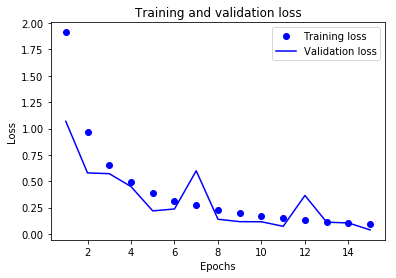

In [18]:
import matplotlib.pyplot as plt

history_dict = history.history 

loss_values = history_dict ['loss'] 

val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)



plt.plot(epochs, loss_values, 'bo', label='Training loss') 

plt.plot(epochs, val_loss_values, 'b', label='Validation loss') 

plt.title('Training and validation loss') 

plt.xlabel('Epochs') 

plt.ylabel('Loss') 

plt.legend()

plt.show()

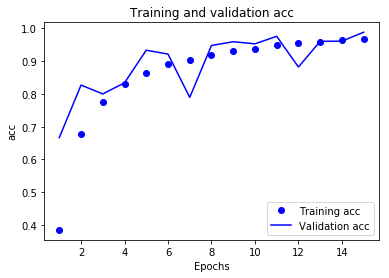

In [19]:
history_dict = history.history 

acc_values = history_dict ['acc'] 

val_acc_values = history_dict['val_acc']



plt.plot(epochs, acc_values, 'bo', label='Training acc') 

plt.plot(epochs, val_acc_values, 'b', label='Validation acc') 

plt.title('Training and validation acc') 

plt.xlabel('Epochs') 

plt.ylabel('acc') 

plt.legend()

plt.show()